# <img style="float: left; padding-right: 10px; width: 45px" src="https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/iacs.png"> CS109A Introduction to Data Science

## Homework 8: Fairness and Bias


**Harvard University**<br/>
**Fall 2020**<br/>
**Instructors**: Pavlos Protopapas, Kevin Rader and Chris Tanner

<hr style="height:2pt">

In [1]:
#RUN THIS CELL 
import requests
from IPython.core.display import HTML
styles = requests.get(
    "https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/cs109.css"
).text
HTML(styles)

In [2]:
import random
random.seed(112358)

import os
import sys

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, roc_auc_score, accuracy_score

%matplotlib inline

<hr style="height:2pt">

### INSTRUCTIONS

- To submit your assignment follow the instructions given in Canvas.

- Please restart the kernel and run the entire notebook again before you submit.

- Running cells out of order is a common pitfall in Jupyter Notebooks. To make sure your code works restart the kernel and run the whole notebook again before you submit. Exceptions should be made for code with an extremely long execution time, of course.
- We have tried to include all the libraries you may need to do the assignment in the imports statement at the top of this notebook. We strongly suggest that you use those and not others as we may not be familiar with them.
- Please use .head() when viewing data. Do not submit a notebook that is **excessively long**. 
- In questions that require code to answer, such as "calculate the $R^2$", do not just output the value from a cell. Write a `print()` function that includes a reference to the calculated value, **not hardcoded**. For example:
```python
print(f'The R^2 is {R:.4f}')
```
- Your plots should be clearly labeled, including clear labels for the $x$ and $y$ axes as well as a descriptive title ("MSE plot" is not a descriptive title; "95% confidence interval of coefficients of polynomial degree 5" is).

<hr style="height:2pt">

## Overview and Data Description

[Table of Contents](#Contents)

In this assignment, we will be analyzing a portion of the data set that [ProPublica](https://www.propublica.org/article/machine-bias-risk-assessments-in-criminal-sentencing) used to report on the effectiveness of and issues surrounding the COMPAS algorithm (as was discussed in lecture 34).  The data are found in the file `compas.csv` and the 'data dictionary' can be found in the file `compas_datadict.csv`, which very briefly explains each variable in the data set.  Please use these files to answer the following questions:

<a id="Contents"></a>

## Contents
- [Question 1 [25 pts]: Data Exploration](#Q1) 
- [Question 2 [15 pts]: Baseline Modeling](#Q2) 
- [Question 3 [15 pts]: Predicting without Race](#Q3)
- [Question 4 [30 pts]: ROC Curves](#Q4)
- [Question 5 [15 pts]: Using Other Models](#Q5)

<a id="Q1"></a>

### <div class='exercise'>Question 1 [25 pts]: Data Wrangling and Exploration</div>
[▲ Return to contents](#Contents)


**1.1** What is the statistical objective of the COMPAS algorithm?  How is recidivism prediction used in courtrooms?

**1.2** Consider the information in the provided `compas_datadict.csv`.  Which variables are raw data?  Which are pre-processed data?  Which is the target variable of the COMPAS algorithm?  Which are output(s) of the COMPAS algorithm?   Which should not be used in building our own model to predict recidivism?  

**1.3** Read-in the data and split into 80% training and 20% test **stratified by `race`** (use `random_state=109`). Before splitting you may want to process the categorical predictors (`['c_charge_degree','race','sex']`) first so you don't have to do it separately in train and test later.

**1.4** Do a little EDA: provide visuals to explore which unprocessed variables (**not** the derived binary varibles, for example) are related to `race`. 

**1.5** Report which 3 variables appear to have the most significant differences between Caucasians and African Americans, and briefly explain with a sentence for each.  

*Note: as illustrated by [ProPublica](https://www.propublica.org/article/machine-bias-risk-assessments-in-criminal-sentencing), reporting on the U.S. Criminal Justice system often concentrate on the disparate experiences between Caucasians and African Americans, thus we have focused our approaches similarly.

**1.6** With respect to these 3 chosen variables, how could bias in the data or data collection be impacting or causing these differences?  Explain in at most 50 words.


### Question 1: Solutions

[▲ Return to contents](#Contents)


**1.1** What is the statistical objective of the COMPAS algorithm?  How is recidivism prediction used in courtrooms?

The statistical objective of the COMPAS algorithm is to predict the recidivism in court judgements. The recidivism prediction is used in courtooms the following way: 
- If someone is predicted with low chances of recidivism, his sentence will be low
- Else, if you are atributed high chances of recidivism, you are likely to spend more time in jail

**1.2** Consider the information in the provided `compas_datadict.csv`.  Which variables are raw data?  Which are pre-processed data?  Which is the target variable of the COMPAS algorithm?  Which are output(s) of the COMPAS algorithm?   Which should not be used in building our own model to predict recidivism?  



In [3]:
data_attributes = pd.read_csv('data/compas_datadict.csv')
data = pd.read_csv('data/compas.csv')
pd.set_option('display.width', 100)
data_attributes

,Variable,Description
0,NaN,NaN
1,Age,Defendant's age in years
2,c_charge_degree,The type of crime a defendant has been charged...
3,race,Defendant's race (categorical)
4,sex,Defendant biological sex (Male/Female)
5,length_of_stay,How long between when a defendant was charged ...
6,length_of_stay_thresh,Thresholded version of length_of_stay variable...
7,priors_count,Count for number of prior times a defendant ha...
8,priors_1,"Indicator variable derived from priors_count, ..."
9,priors_234,"Indicator variable derived from priors_count, ..."


- Raw data: Age, c_charge_degree, race, sex, length_of_stay, priors_count, juv_fel_count, juv_misd_count, juv_other_count, c_charge_desc
- Preprocessed data: length_of_stay_thresh, priors_1, priors_234, priors_5plus, juv_fel_1plus, juv_misd_1plus, juv_other_1plus, charge_any_drug, charge_any_violence_aggression, charge_any_theft, score_text, decile_score, two_year_recid
- Target variable of the COMPAS algorithm: two_year_recid
- Output variable of the COMPAS: score_text, decile_score

The variable that should not be used in our own model to predict recidivism: race.

**1.3** Read-in the data and split into 80% training and 20% test **stratified by `race`** (use `random_state=109`). Before splitting you may want to process the categorical predictors (`['c_charge_desc','race','sex']`) first so you don't have to do it separately in train and test later.

In [4]:
# your code here
data['Sex'] = 1*(data['sex']=='Male')
data.drop('sex', axis=1, inplace=True)
data['c_charge_deg_cat'] = 1*(data['c_charge_degree']=='F')
data.drop('c_charge_degree', axis=1, inplace=True)
dummies = pd.get_dummies(data['race'])
dummies.columns = [column + ' race' for column in dummies.columns]
data = data.join(dummies)
X_train, X_test, y_train, y_test = train_test_split(data.drop('two_year_recid', axis=1), data['two_year_recid'], train_size = 0.8, random_state=109, stratify=data['race'])

**1.4** Do a little EDA: provide visuals to explore which unprocessed variables (**not** the derived binary varibles, for example) are related to `race`. 

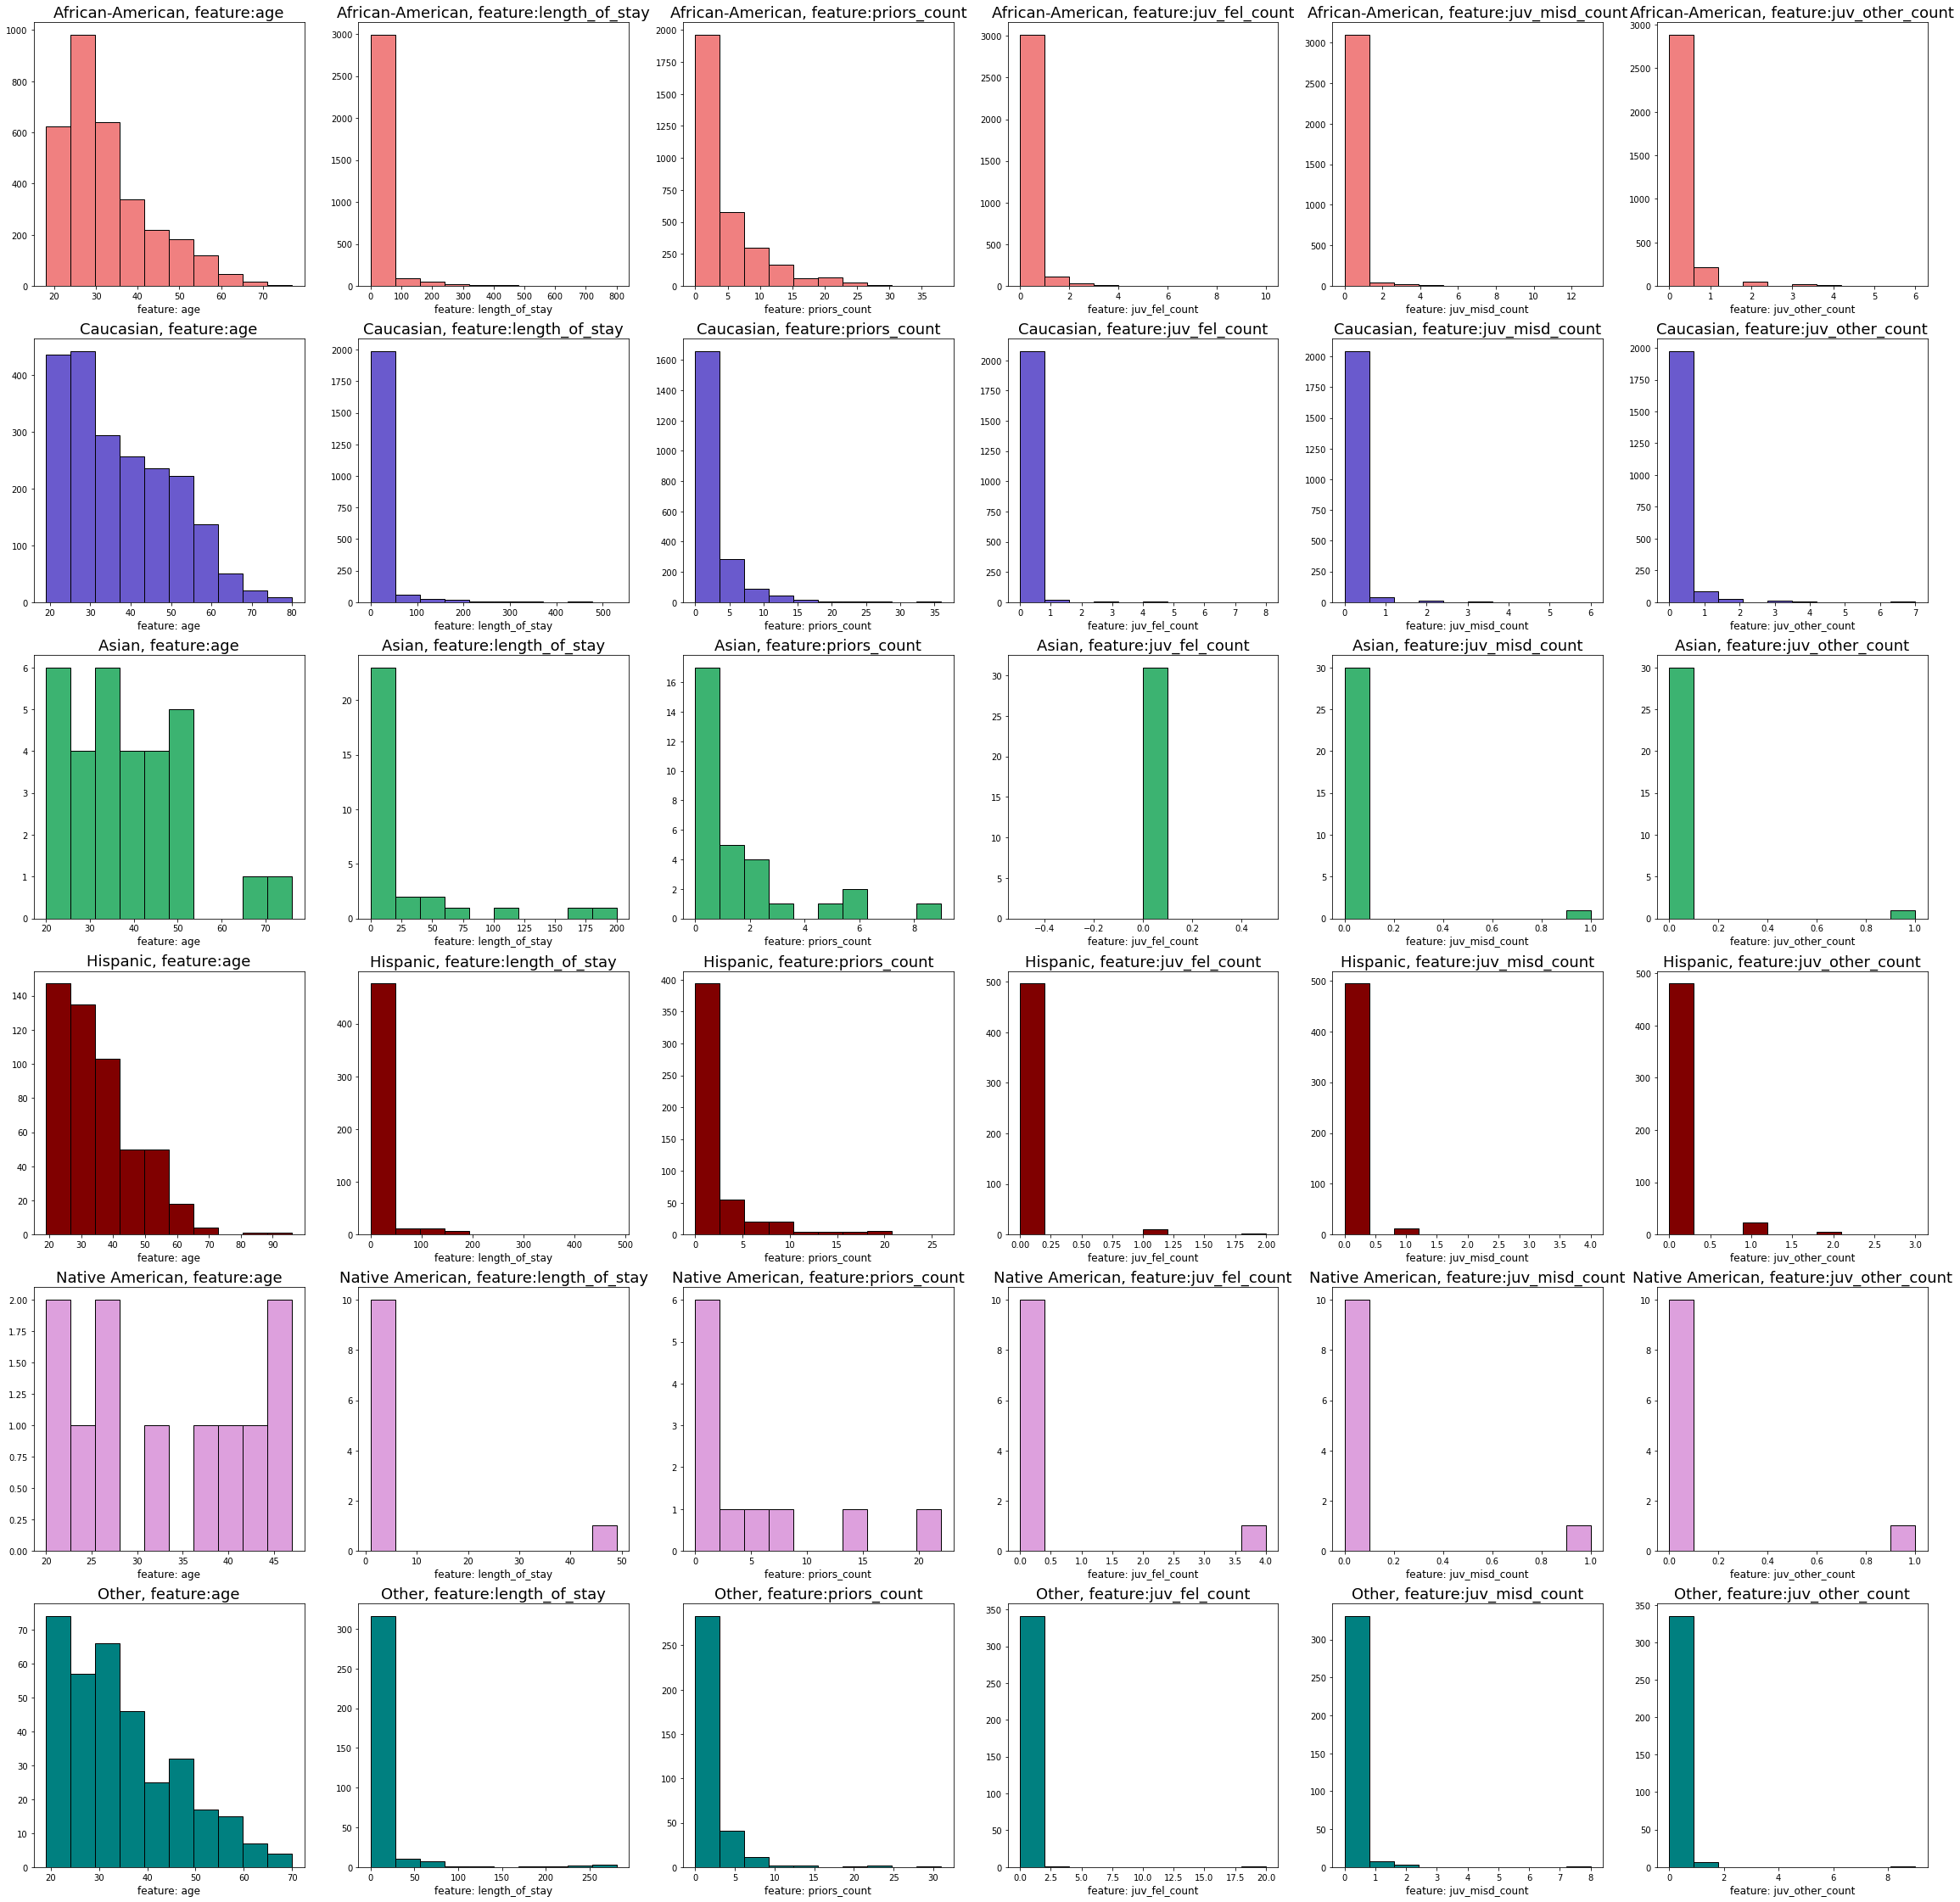

In [5]:
# your code here
features = ['age', 'length_of_stay', 'priors_count', 'juv_fel_count', 'juv_misd_count', 'juv_other_count']
mask_africana = (data['African-American race']==1)
mask_asian = (data['Asian race']==1)
mask_caucasian = (data['Caucasian race']==1)
mask_hispanic = (data['Hispanic race']==1)
mask_nativea = (data['Native American race']==1)
mask_other = (data['Other race']==1)

data_africana = data[mask_africana]
data_asian = data[mask_asian]
data_caucasian = data[mask_caucasian]
data_hispanic = data[mask_hispanic]
data_nativea = data[mask_nativea]
data_other = data[mask_other]

fig, ax = plt.subplots(nrows = 6, ncols = 6, figsize = (40,40))
for idx, feature in enumerate(features):
    ax[0,idx].hist(data_africana[feature],edgecolor='black', color = 'lightcoral')
    ax[1,idx].hist(data_caucasian[feature],edgecolor='black', color = 'slateblue')
    ax[2,idx].hist(data_asian[feature],edgecolor='black', color = 'mediumseagreen')
    ax[3,idx].hist(data_hispanic[feature],edgecolor='black', color = 'maroon')
    ax[4,idx].hist(data_nativea[feature],edgecolor='black', color = 'plum')
    ax[5,idx].hist(data_other[feature],edgecolor='black', color = 'teal')
    ax[0,idx].set_xlabel(r'feature: ' + str(feature), fontsize = 12)
    ax[1,idx].set_xlabel(r'feature: ' + str(feature), fontsize = 12)
    ax[2,idx].set_xlabel(r'feature: ' + str(feature), fontsize = 12)
    ax[3,idx].set_xlabel(r'feature: ' + str(feature), fontsize = 12)
    ax[4,idx].set_xlabel(r'feature: ' + str(feature), fontsize = 12)
    ax[5,idx].set_xlabel(r'feature: ' + str(feature), fontsize = 12)
    ax[0,idx].set_title(r'African-American, feature:' + str(feature), fontsize = 18)
    ax[1,idx].set_title(r'Caucasian, feature:' + str(feature), fontsize = 18)
    ax[2,idx].set_title(r'Asian, feature:' + str(feature), fontsize = 18)
    ax[3,idx].set_title(r'Hispanic, feature:' + str(feature), fontsize = 18)
    ax[4,idx].set_title(r'Native American, feature:' + str(feature), fontsize = 18)
    ax[5,idx].set_title(r'Other, feature:' + str(feature), fontsize = 18)


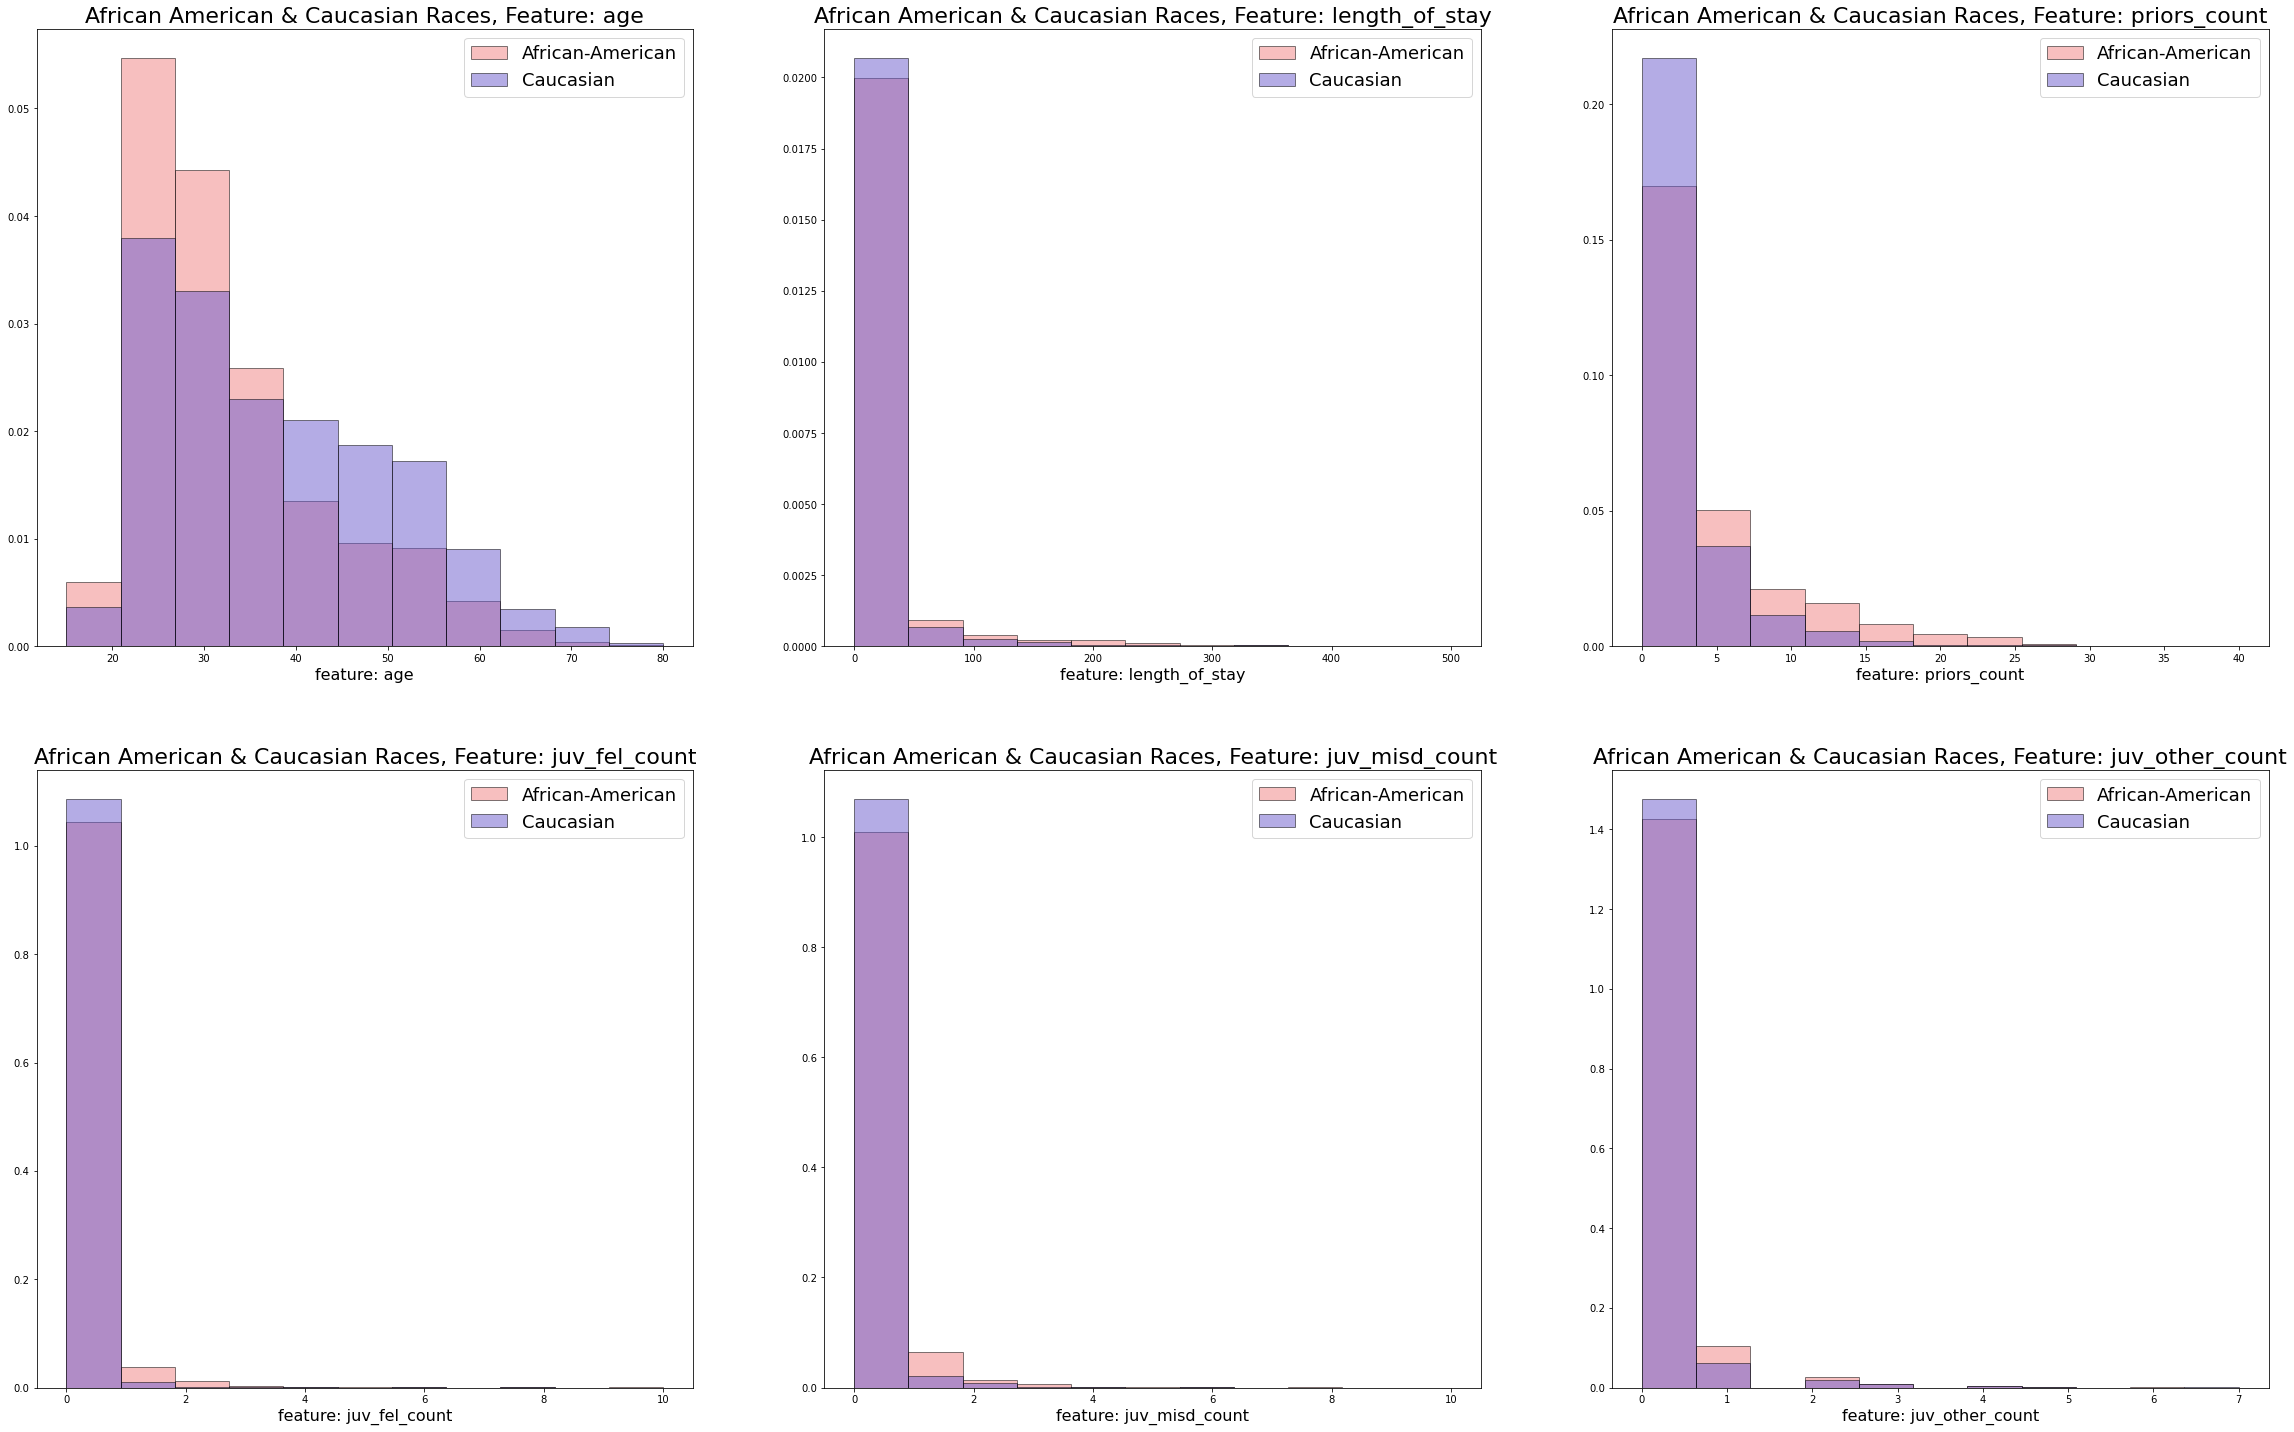

In [6]:
# your code here
features = ['age', 'length_of_stay', 'priors_count', 'juv_fel_count', 'juv_misd_count', 'juv_other_count']
mask_africana = (data['African-American race']==1)
mask_caucasian = (data['Caucasian race']==1)
#bins = np.linspace(0, 100, 10)
bins = [np.linspace(15, 80, 12),np.linspace(0, 500, 12),np.linspace(0, 40, 12),np.linspace(0, 10, 12),np.linspace(0, 10, 12),np.linspace(0, 7, 12)]

data_africana = data[mask_africana]
data_caucasian = data[mask_caucasian]

fig, ax = plt.subplots(nrows = 2, ncols = 3, figsize = (40,25))
ax = ax.ravel()
for idx, feature in enumerate(features):
    ax[idx].hist(data_africana[feature], bins[idx], color = 'lightcoral', alpha = 0.5, density = True, edgecolor='k', label = 'African-American')
    ax[idx].hist(data_caucasian[feature], bins[idx], color = 'slateblue', alpha = 0.5, density = True, edgecolor='k', label = 'Caucasian')
    ax[idx].set_xlabel(r'feature: ' + str(feature), fontsize = 16)
    ax[idx].set_title(r'African American & Caucasian Races, Feature: ' + str(feature), fontsize = 22)
    ax[idx].legend(loc='best', prop={'size': 18})


**1.5** Report which 3 variables appear to have the most significant differences between Caucasians and African Americans, and briefly explain with a sentence for each.  

*Note: as illustrated by [ProPublica](https://www.propublica.org/article/machine-bias-risk-assessments-in-criminal-sentencing), reporting on the U.S. Criminal Justice system often concentrate on the disparate experiences between Caucasians and African Americans, thus we have focused our approaches similarly.



From the figure above, we observe the following three variables that appear to have the most significant differences between Caucasian and African American defendents:
- **Age** - It appears that the African-American defendents are in general significantly younger than the Caucasian defendents, i.e. the distribution for Caucasian defendents is more spread out, where the distribution for African-American defedents has larger peak value for younger defendents.
- **priors_count** - Both distributions are right skewed, but the distribution for African-American defendents is more spread out, where the distribution for Caucasian defendents has higher peak value at zero (0 prior arrests).
- **juv_misd_count** - It appears as for the Caucasian defendents the overwhelming majority has zero juvenile misdemeanor charges, while we see an observably larger number of African-American defendents with one juvenile misdemeanor charge.

**1.6** With respect to these 3 chosen variables, how could bias in the data or data collection be impacting or causing these differences?  Explain in at most 50 words.


The bias in the data/data collection and its impacts can be explained by the Kansas city experiment discussed in lecture. I.e. the reason that the number of African-American defendents with one or more **prior_count** and **juv_misd_count** is significantly larger in comparison to the Caucasian defendents is that the police patrols are more likely to conduct patrols and consequently arrests in areas with predominantly African-American population. Thus the data tells us a sotry about unjust policing practices and injustice within judicial policy.

---

<a id="Q2"></a>

### <div class='exercise'>Question 2 [15 pts]: Baseline Modeling</div>
[▲ Return to contents](#Contents)


**2.1**  Build a logistic regression model to predict recidivism (`two_year_recid`) from the relevant predictors (including `race`).  Interpret what this model is saying about the relationship of `two_year_recid` to `race`.


**2.2**  Report the following on the **test set**:
1. Overall model accuracy as a percentage
2. **False Positive Rate(FPR)** as a percentage for the groups (*note a positive here is `two_year_recid==1`)
    - `African-American`
    - `Cacausian`
3. **False Negative Rate(FNR)** as a percentage for the groups:
    - `African-American`
    - `Caucasian`
4. Ratios of Error Rates:
    - Ratio of the FPR between `African-American` and `Caucasian` groups
    - Ratio of the FNR between `African-American` and `Caucasian` groups

i.e $\frac{FPR(AA)}{FPR(CC)}$ and $\frac{FNR(AA)}{FNR(CC)}$

**2.3**  What do you observe? Is there any disparity in the $FPR$ and $FNR$ for the two groups?
Explain your findings in 3-6 sentences.
    
  

### Question 2: Solutions

[▲ Return to contents](#Contents)


**2.1**  Build a logistic regression model to predict recidivism (`two_year_recid`) from the relevant predictors (including `race`).  Interpret what this model is saying about the relationship of `two_year_recid` to `race`.   
  

In [7]:
to_drop = ['race', 'c_charge_desc', 'score_text']
X_train.drop(to_drop, axis=1, inplace=True)
X_test.drop(to_drop, axis=1, inplace=True)

In [8]:
# your code here
model = LogisticRegression(max_iter = 2000).fit(X_train, y_train)
dict_interesting_scores = {column: model.coef_[0][i] for i, column in enumerate(X_train.columns) if 'race' in column}
for race in dict_interesting_scores:
    print(race + ' : ' + str(dict_interesting_scores.get(race)))


African-American race : 0.1541336096129373
Asian race : -0.2636299367666399
Caucasian race : 0.1650229778504439
Hispanic race : 0.01718226479193281
Native American race : -0.7200722398413646
Other race : 0.08488100843793536


This Logistic Regression explicitely states that: 
- Being an African American, a Causasian, a Hispanic or from another race contributes to leading to the conclusion that the individual is likely to perform recidivism within 2 years
- Being an Asian or a Native American diminishes the likelihood of committing recidivism

**2.2**  Report the following on the **test set**:
1. Overall model accuracy as a percentage
2. **False Positive Rate(FPR)** as a percentage for the groups (*note a positive here is `two_year_recid==1`)
    - `African-American`
    - `Cacausian`
3. **False Negative Rate(FNR)** as a percentage for the groups:
    - `African-American`
    - `Caucasian`
4. Ratios of Error Rates:
    - Ratio of the FPR between `African-American` and `Caucasian` groups
    - Ratio of the FNR between `African-American` and `Caucasian` groups

i.e $\frac{FPR(AA)}{FPR(CC)}$ and $\frac{FNR(AA)}{FNR(CC)}$



In [9]:
# your code here
test_score = model.score(X_test, y_test)
print('The overall model accuracy between classes on the test set is {:.4f}'.format(test_score))

The overall model accuracy between classes on the test set is 0.6834


#### False positives

In [10]:
def get_fpr(group, X_test, model, y_test):
    X_test_here = X_test.reset_index(drop=True)
    mask = (X_test_here[group[0]]==1)
    X_test_here = X_test_here[mask]
    predictions = model.predict(X_test_here)
    y_test_here = y_test[mask]
    fp = 0
    for i, prediction in enumerate(predictions):
        if prediction == 1 and y_test_here[i] == 0:
            fp += 1
    return fp/len(y_test)

For the group African-American

In [11]:
column_selected = [column for column in X_test.columns if 'African' in column]
fpr_aa = get_fpr(column_selected, X_test, model, y_test.values)
print('The false positive rates for the ', column_selected, 'group is {:.4f}'.format(fpr_aa))

The false positive rates for the  ['African-American race'] group is 0.0834


For the group Caucasian

In [12]:
column_selected = [column for column in X_test.columns if 'Caucasian' in column]
fpr_c = get_fpr(column_selected, X_test, model, y_test.values)
print('The false positive rates for the ', column_selected, 'group is {:.4f}'.format(fpr_c))

The false positive rates for the  ['Caucasian race'] group is 0.0356


#### False negatives

In [13]:
def get_fnr(group, X_test, model, y_test):
    X_test_here = X_test.reset_index(drop=True)
    mask = (X_test_here[group[0]]==1)
    X_test_here = X_test_here[mask]
    predictions = model.predict(X_test_here)
    y_test_here = y_test[mask]
    fn = 0
    for i, prediction in enumerate(predictions):
        if prediction == 0 and y_test_here[i] == 1:
            fn += 1
    return fn/len(y_test)

For the group African-American

In [14]:
column_selected = [column for column in X_test.columns if 'African' in column]
fnr_aa = get_fnr(column_selected, X_test, model, y_test.values)
print('The false positive rates for the ', column_selected, 'group is {:.4f}'.format(fnr_aa))

The false positive rates for the  ['African-American race'] group is 0.0826


For the group Caucasian

In [15]:
column_selected = [column for column in X_test.columns if 'Caucasian' in column]
fnr_c = get_fnr(column_selected, X_test, model, y_test.values)
print('The false positive rates for the ', column_selected, 'group is {:.4f}'.format(fnr_c))

The false positive rates for the  ['Caucasian race'] group is 0.0623


#### Ratios of Error Rates

In [16]:
fpr_ratio = fpr_aa/fpr_c
print('The ratio of false positives is {:.4f}'.format(fpr_ratio))
fnr_ratio = fnr_aa/fnr_c
print('The ratio of false negatives is {:.4f}'.format(fnr_ratio))

The ratio of false positives is 2.3409
The ratio of false negatives is 1.3247


**2.3**  What do you observe? Is there any disparity in the $FPR$ and $FNR$ for the two groups?
Explain your findings in 3-6 sentences.
 

Two observations come from the previous work we have just done:
- The false negative rates are comparable, meaning that for both groups, the model performs False predictions whereas it should be true almost as much for Causasian than African Americans. On that point, neither group is favoured by the algorithm. 
- However, the false positive rates are not at all comparable. This means that there are a lot of African American people that are classified as recidivists where as they should not be. This is where the bias lias in this algorithm: one subgroup is favored whereas another is punished and is more often predicted as recidivist.

---

<a id="Q3"></a>

### <div class='exercise'>Question 3 [15 pts]: Predicting Recidivism without using `race`</div>
[▲ Return to contents](#Contents)


**3.1** Refit the logistic model in 2.1 but this time **without** `race` as a predictor. 

**3.2** Again, report the following on the **test set**:
1. Overall model accuracy as a percentage
2. **False Positive Rate(FPR)** as a percentage for the groups (*note a positive here is `two_year_recid==1`)
    - `African-American`
    - `Cacausian`
3. **False Negative Rate(FNR)** as a percentage for the groups:
    - `African-American`
    - `Caucasian`
4. Ratios of Error Rates:
    - Ratio of the FPR between `African-American` and `Caucasian` groups
    - Ratio of the FNR between `African-American` and `Caucasian` groups

**3.3**  How do these metrics compare to the model when the variable `race` **is** included as a predictor?

**3.4**  Given your exploration and modeling of the data, should a predictive tool be trusted to be unbiased even if it doesn’t explicitly use a variable such as race to predict future crime?  Why or why not?  Why is the bias still occurring or not occurring?  Explain using at most 150 words.
 

### Question 3: Solutions

[▲ Return to contents](#Contents)


**3.1** Refit the logistic model in 2.1 but this time **without** `race` as a predictor. 

In [17]:
to_drop_race = [column for column in X_train.columns if 'race' in column]
X_train_unbias = X_train.drop(to_drop_race, axis=1)
X_test_unbias = X_test.drop(to_drop_race, axis=1)

In [18]:
# your code here
model = LogisticRegression(max_iter = 2000).fit(X_train_unbias, y_train)

**3.2** Again, report the following on the **test set**:
1. Overall model accuracy as a percentage
2. **False Positive Rate(FPR)** as a percentage for the groups (*note a positive here is `two_year_recid==1`)
    - `African-American`
    - `Cacausian`
3. **False Negative Rate(FNR)** as a percentage for the groups:
    - `African-American`
    - `Caucasian`
4. Ratios of Error Rates:
    - Ratio of the FPR between `African-American` and `Caucasian` groups
    - Ratio of the FNR between `African-American` and `Caucasian` groups



In [19]:
test_score = model.score(X_test_unbias, y_test)
print('The overall model accuracy between classes on the test set is {:.4f}'.format(test_score))


The overall model accuracy between classes on the test set is 0.6834


#### False positives

In [20]:
def get_unbiased_fpr(group, X_test, model, y_test, to_drop):
    X_test_here = X_test.reset_index(drop=True)
    mask = (X_test_here[group[0]]==1)
    X_test_here = X_test_here[mask]
    X_test_here = X_test_here.drop(to_drop, axis=1)
    predictions = model.predict(X_test_here)
    y_test_here = y_test[mask]
    fp = 0
    for i, prediction in enumerate(predictions):
        if prediction == 1 and y_test_here[i] == 0:
            fp += 1
    return fp/len(y_test)

For African American

In [21]:
# your code here
column_selected = [column for column in X_test.columns if 'African' in column]
fpr_aa = get_unbiased_fpr(column_selected, X_test, model, y_test.values, to_drop_race)
print('The false positive rates for the ', column_selected, 'group is {:.4f}'.format(fpr_aa))

The false positive rates for the  ['African-American race'] group is 0.0826


For Caucasian

In [22]:
# your code here
column_selected = [column for column in X_test.columns if 'Caucasian' in column]
fpr_c = get_unbiased_fpr(column_selected, X_test, model, y_test.values, to_drop_race)
print('The false positive rates for the ', column_selected, 'group is {:.4f}'.format(fpr_c))

The false positive rates for the  ['Caucasian race'] group is 0.0348


#### False negatives

In [23]:
def get_unbiased_fnr(group, X_test, model, y_test, to_drop):
    X_test_here = X_test.reset_index(drop=True)
    mask = (X_test_here[group[0]]==1)
    X_test_here = X_test_here[mask]
    X_test_here = X_test_here.drop(to_drop, axis=1)
    predictions = model.predict(X_test_here)
    y_test_here = y_test[mask]
    fn = 0
    for i, prediction in enumerate(predictions):
        if prediction == 0 and y_test_here[i] == 1:
            fn += 1
    return fn/len(y_test)

For African American

In [24]:
# your code here
column_selected = [column for column in X_test.columns if 'African' in column]
fnr_aa = get_unbiased_fnr(column_selected, X_test, model, y_test.values, to_drop_race)
print('The false positive rates for the ', column_selected, 'group is {:.4f}'.format(fnr_aa))

The false positive rates for the  ['African-American race'] group is 0.0834


For Caucasian

In [25]:
# your code here
column_selected = [column for column in X_test.columns if 'Caucasian' in column]
fnr_c = get_unbiased_fnr(column_selected, X_test, model, y_test.values, to_drop_race)
print('The false positive rates for the ', column_selected, 'group is {:.4f}'.format(fnr_c))

The false positive rates for the  ['Caucasian race'] group is 0.0640


#### Ratio of Error Rates

In [26]:
fpr_ratio = fpr_aa/fpr_c
print('The ratio of false positives is {:.4f}'.format(fpr_ratio))
fnr_ratio = fnr_aa/fnr_c
print('The ratio of false negatives is {:.4f}'.format(fnr_ratio))

The ratio of false positives is 2.3721
The ratio of false negatives is 1.3038


**3.3**  How do these metrics compare to the model when the variable `race` **is** included as a predictor?



We can see that there is very little difference in those metrics when compared to those metrics when the race was not used as a predictor. 

**3.4**  Given your exploration and modeling of the data, should a predictive tool be trusted to be unbiased even if it doesn’t explicitly use a variable such as race to predict future crime?  Why or why not?  Why is the bias still occurring or not occurring?  Explain using at most 150 words.
 

A predictive tool should not be trusted to be unbiased even if it doesn’t explicitly use a variable such as race to predict future crime. This comes under the problem of algorithmic fairness and algorithm unbiasness. From our previous experience, we have seen that even when an explicit variable is not used, there is bias in the data that accounts for this variable, like other variables that act as proxy of this variable. This can be seen in the correlation between variables, whether it is simple or multi-correlation. 

---

<a id="Q4"></a>

### <div class='exercise'>Question 4 [30 pts]: ROC Curves</div>
[▲ Return to contents](#Contents)


**4.1** Use the logistic regression from 3.1 and plot the *Receiver Operating Characteristic (ROC) curve* for two racial groups: `African-American` & `Caucasian` in the test set. 
    
**4.2** The default threshold used for determining the metrics in 2.2 and 3.2 was 0.5.  Choose a new single threshold for the model from 3.1 that may will reduce the bias between these two racial groups (as measured by the ratios of FPR and FNR).  Be sure to briefly justify your choice (Note: there is no one correct answer).

**4.3** A second approach to reducing bias is to use different thresholds for the different racial groups to better ensure that the groups have similar false positive and false negative rates.  Choose a pair of thresholds (one for the `African-American` group and one for the `Caucasian` group) that improves the group bias (balanced with accuracy). Be sure to briefly justify your choice

**4.4** Comment on the [fairness](https://en.wikipedia.org/wiki/Fairness_(machine_learning)) of the two methods in 4.2 and 4.3 from two different perspectives: the fairness of each group (called 'group fairness') and the fairness for an individual defendant (called 'individual fairness').  Please limit your response to at most 75 words. 

**4.5** Changing the thresholds can *reduce* bias between the two classes, but it can also affect model accuracy. We want our model to be **accurate** but also **fair**.  What can be done to balance these two criteria?  Write down your strategy to overcome this difficulty.   Please limit your response to at most 150 words.  
     

### Question 4: Solutions

[▲ Return to contents](#Contents)


**4.1** Use the logistic regression from 3.1 and plot the *Receiver Operating Characteristic (ROC) curve* for two racial groups: `African-American` & `Caucasian` in the test set. 
        

For the African American 

In [27]:
column_selected = [column for column in X_test.columns if 'African' in column]
X_test_here = X_test.reset_index(drop=True)
mask = X_test_here[column_selected[0]]==1
X_test_here = X_test_here[mask]
X_test_here = X_test_here.drop(to_drop_race, axis=1)
predictions = model.predict_proba(X_test_here)
y_test_here = y_test.values[mask]
fpr_aa, tpr_aa, thresholds = roc_curve(y_test_here.tolist(), predictions[:, 1])

In [28]:
column_selected = [column for column in X_test.columns if 'Caucasian' in column]
X_test_here = X_test.reset_index(drop=True)
mask = X_test_here[column_selected[0]]==1
X_test_here = X_test_here[mask]
X_test_here = X_test_here.drop(to_drop_race, axis=1)
predictions = model.predict_proba(X_test_here)
y_test_here = y_test.values[mask]
fpr_c, tpr_c, thresholds = roc_curve(y_test_here.tolist(), predictions[:, 1])

C:\Users\David\Anaconda3\envs\cs109a\lib\site-packages\ipykernel_launcher.py:10: MatplotlibDeprecationWarning: The 's' parameter of annotate() has been renamed 'text' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  # Remove the CWD from sys.path while we load stuff.


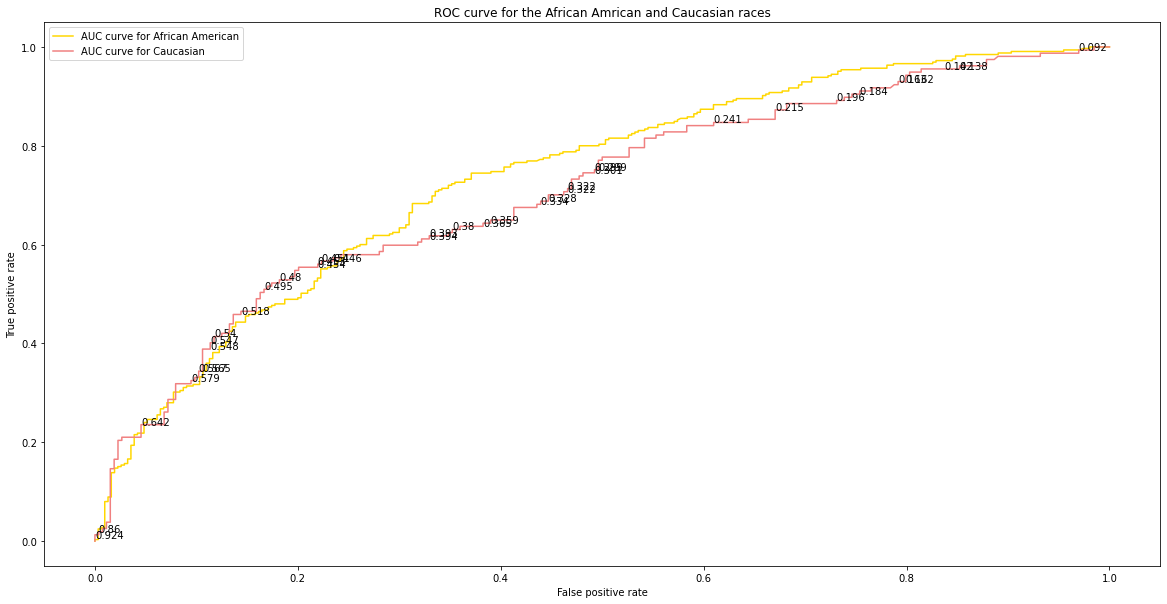

In [29]:
# your code here
fig, ax = plt.subplots(1, figsize = (20, 10))
ax.set_title('ROC curve for the African Amrican and Caucasian races')
ax.plot(fpr_aa, tpr_aa, label='AUC curve for African American', color='gold')
ax.plot(fpr_c, tpr_c, label='AUC curve for Caucasian', color='lightcoral')
ax.set_xlabel('False positive rate')
ax.set_ylabel('True positive rate')
for i, threshold in enumerate(thresholds):
    if np.random.uniform() < 0.2:
        ax.annotate(xy=(fpr_c[i], tpr_c[i]), s=round(threshold, 3))
ax.legend()
plt.show()

**4.2** The default threshold used for determining the metrics in 2.2 and 3.2 was 0.5.  Choose a new single threshold for the model from 3.1 that may will reduce the bias between these two racial groups (as measured by the ratios of FPR and FNR).  Be sure to briefly justify your choice (Note: there is no one correct answer).



#### False positives

In [30]:
# your code here
def get_unbiased_newth_fpr(group, X_test, model, y_test, to_drop, threshold):
    X_test_here = X_test.reset_index(drop=True)
    mask = (X_test_here[group[0]]==1)
    X_test_here = X_test_here[mask]
    X_test_here = X_test_here.drop(to_drop, axis=1)
    predictions = np.where(model.predict_proba(X_test_here)[:,1] > threshold, 1, 0)
    y_test_here = y_test[mask]
    fp = 0
    for i, prediction in enumerate(predictions):
        if prediction == 1 and y_test_here[i] == 0:
            fp += 1
    return fp/len(y_test)

In [31]:
fpr_aa = []
fpr_c = []
ratios_fpr = []
thresholds = np.linspace(0.1,0.85,16)
column_selected_aa = [column for column in X_test.columns if 'African' in column]
column_selected_c = [column for column in X_test.columns if 'Caucasian' in column]

for threshold in thresholds:
    fpr_aa.append(get_unbiased_newth_fpr(column_selected_aa, X_test, model, y_test.values, to_drop_race, threshold))
    fpr_c.append(get_unbiased_newth_fpr(column_selected_c, X_test, model, y_test.values, to_drop_race, threshold))
    ratios_fpr.append((get_unbiased_newth_fpr(column_selected_aa, X_test, model, y_test.values, to_drop_race, threshold))/(get_unbiased_newth_fpr(column_selected_c, X_test, model, y_test.values, to_drop_race, threshold)))
res_ratios_fpr = dict(zip(thresholds, ratios_fpr))
print(res_ratios_fpr)


{0.1: 1.2310756972111554, 0.15000000000000002: 1.3472222222222223, 0.2: 1.4761904761904763, 0.25: 1.639240506329114, 0.30000000000000004: 1.7384615384615387, 0.35: 1.8165137614678901, 0.4: 1.8470588235294116, 0.45000000000000007: 2.152542372881356, 0.5: 2.372093023255814, 0.55: 2.964285714285714, 0.6: 3.285714285714286, 0.65: 4.166666666666666, 0.7000000000000001: 6.333333333333333, 0.75: 6.000000000000001, 0.8: 2.75, 0.85: 1.6666666666666665}


#### False negatives

In [32]:
def get_unbiased_newth_fnr(group, X_test, model, y_test, to_drop, threshold):
    X_test_here = X_test.reset_index(drop=True)
    mask = (X_test_here[group[0]]==1)
    X_test_here = X_test_here[mask]
    X_test_here = X_test_here.drop(to_drop, axis=1)
    predictions = np.where(model.predict_proba(X_test_here)[:,1] > threshold, 1, 0)
    y_test_here = y_test[mask]
    fn = 0
    for i, prediction in enumerate(predictions):
        if prediction == 0 and y_test_here[i] == 1:
            fn += 1
    return fn/len(y_test)

In [33]:
fnr_aa = []
fnr_c = []
ratios_fnr = []
thresholds = np.linspace(0.1,0.85,16)
column_selected_aa = [column for column in X_test.columns if 'African' in column]
column_selected_c = [column for column in X_test.columns if 'Caucasian' in column]

for threshold in thresholds:
    fnr_aa.append(get_unbiased_newth_fnr(column_selected_aa, X_test, model, y_test.values, to_drop_race, threshold))
    fnr_c.append(get_unbiased_newth_fnr(column_selected_c, X_test, model, y_test.values, to_drop_race, threshold))
    ratios_fnr.append((get_unbiased_newth_fnr(column_selected_aa, X_test, model, y_test.values, to_drop_race, threshold))/(get_unbiased_newth_fnr(column_selected_c, X_test, model, y_test.values, to_drop_race, threshold)))
res_ratios_fnr = dict(zip(thresholds, ratios_fnr))
print(res_ratios_fnr)


{0.1: 0.0, 0.15000000000000002: 0.42857142857142855, 0.2: 0.2222222222222222, 0.25: 0.36, 0.30000000000000004: 0.45, 0.35: 0.6181818181818183, 0.4: 0.9838709677419355, 0.45000000000000007: 1.1470588235294117, 0.5: 1.3037974683544302, 0.55: 1.2989690721649483, 0.6: 1.3727272727272728, 0.65: 1.4146341463414633, 0.7000000000000001: 1.550387596899225, 0.75: 1.6861313868613137, 0.8: 1.7651006711409396, 0.85: 1.9407894736842104}


C:\Users\David\Anaconda3\envs\cs109a\lib\site-packages\ipykernel_launcher.py:5: MatplotlibDeprecationWarning: The 's' parameter of annotate() has been renamed 'text' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  """
C:\Users\David\Anaconda3\envs\cs109a\lib\site-packages\ipykernel_launcher.py:6: MatplotlibDeprecationWarning: The 's' parameter of annotate() has been renamed 'text' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  


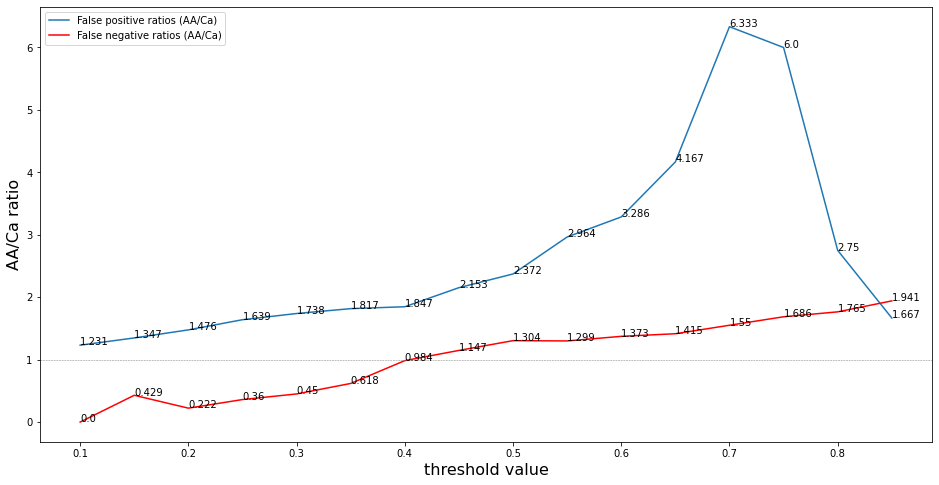

In [34]:
fig, ax = plt.subplots(figsize = (16,8))
ax.plot(thresholds, ratios_fpr, label = 'False positive ratios (AA/Ca)')
ax.plot(thresholds, ratios_fnr, label = 'False negative ratios (AA/Ca)', color = 'red')
for i, threshold in enumerate(thresholds):
    ax.annotate(xy=(threshold, ratios_fpr[i]), s=round(ratios_fpr[i], 3))
    ax.annotate(xy=(threshold, ratios_fnr[i]), s=round(ratios_fnr[i], 3))
ax.set_xlabel('threshold value', fontsize = 16)
ax.set_ylabel('AA/Ca ratio', fontsize = 16)
ax.axhline(1, color = 'grey', linestyle = '--', lw = 0.5)
ax.legend(loc='best')

Using the analysis above, the new single threshold chosen for the model from 3.1 that reduces the bias between the two racial groups (as measured by the ratios of FPR and FNR) is: $0.4$. The strategy behind this choice was the following:
- First we performed a grid search over the "reasonable" possible threshold values: $threshold \in [0.1,0.85]$.
- Then we calculated the ratios of the FPRs and FNRs for the two groups.
- The threshold value that reduces the bias between the two racial groups the most is the one for which the FPRs and FNRs ratios are closest to $1$.
- Thus we chose the value of $0.4$ as the single threshold value.

**4.3** A second approach to reducing bias is to use different thresholds for the different racial groups to better ensure that the groups have similar false positive and false negative rates.  Choose a pair of thresholds (one for the `African-American` group and one for the `Caucasian` group) that improves the group bias (balanced with accuracy). Be sure to briefly justify your choice



#### False positives

In [35]:
fpr_aa = []
fpr_c = []
ratios_fpr = []
thresholds_combined = []
thresholds_aa = np.linspace(0.2,0.8,7)
thresholds_c = np.linspace(0.2,0.8,7)
column_selected_aa = [column for column in X_test.columns if 'African' in column]
column_selected_c = [column for column in X_test.columns if 'Caucasian' in column]

for threshold_aa in thresholds_aa:
    for threshold_c in thresholds_c:
        fpr_aa.append(get_unbiased_newth_fpr(column_selected_aa, X_test, model, y_test.values, to_drop_race, threshold_aa))
        fpr_c.append(get_unbiased_newth_fpr(column_selected_c, X_test, model, y_test.values, to_drop_race, threshold_c))
        ratios_fpr.append((get_unbiased_newth_fpr(column_selected_aa, X_test, model, y_test.values, to_drop_race, threshold_aa))/(get_unbiased_newth_fpr(column_selected_c, X_test, model, y_test.values, to_drop_race, threshold_c)))
        thresholds_combined.append('aa_th=' +str(threshold_aa)+ '; c_th=' +str(threshold_c))
res_ratios_fpr = dict(zip(thresholds_combined, ratios_fpr))
#print(res_ratios_fpr)

Text(69.0, 0.5, 'Threshold African-American')

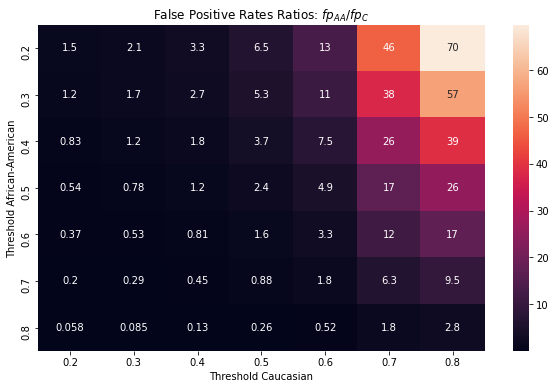

In [36]:
ratios_fpr_np = np.array(ratios_fpr).reshape(7,7)
ratios_fpr_pd = pd.DataFrame(ratios_fpr_np, columns = [0.2,0.3,0.4,0.5,0.6,0.7,0.8], index = [0.2,0.3,0.4,0.5,0.6,0.7,0.8])
fig, ax = plt.subplots(figsize = (10,6))
ax0 = sns.heatmap(ratios_fpr_pd, annot=True, ax = ax)
ax.set_title('False Positive Rates Ratios: $fp_{AA}/fp_C$')
ax.set_xlabel('Threshold Caucasian')
ax.set_ylabel('Threshold African-American')


#### False negatives

In [37]:
fnr_aa = []
fnr_c = []
ratios_fnr = []
thresholds_combined = []
thresholds_aa = np.linspace(0.2,0.8,7)
thresholds_c = np.linspace(0.2,0.8,7)
column_selected_aa = [column for column in X_test.columns if 'African' in column]
column_selected_c = [column for column in X_test.columns if 'Caucasian' in column]

for threshold_aa in thresholds_aa:
    for threshold_c in thresholds_c:
        fnr_aa.append(get_unbiased_newth_fnr(column_selected_aa, X_test, model, y_test.values, to_drop_race, threshold_aa))
        fnr_c.append(get_unbiased_newth_fnr(column_selected_c, X_test, model, y_test.values, to_drop_race, threshold_c))
        ratios_fnr.append((get_unbiased_newth_fnr(column_selected_aa, X_test, model, y_test.values, to_drop_race, threshold_aa))/(get_unbiased_newth_fnr(column_selected_c, X_test, model, y_test.values, to_drop_race, threshold_c)))
        thresholds_combined.append('aa_th=' +str(threshold_aa)+ '; c_th=' +str(threshold_c))
res_ratios_fnr = dict(zip(thresholds_combined, ratios_fnr))
#print(res_ratios_fnr)

Text(69.0, 0.5, 'Threshold African-American')

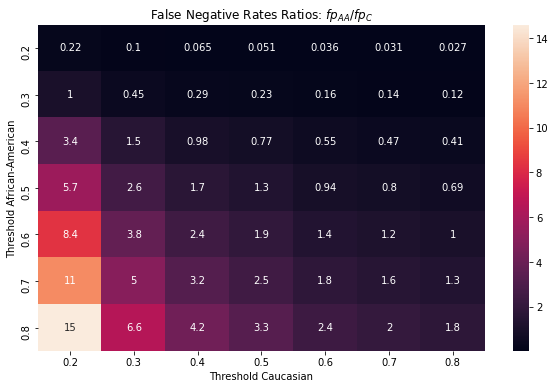

In [38]:
ratios_fnr_np = np.array(ratios_fnr).reshape(7,7)
ratios_fnr_pd = pd.DataFrame(ratios_fnr_np, columns = [0.2,0.3,0.4,0.5,0.6,0.7,0.8], index = [0.2,0.3,0.4,0.5,0.6,0.7,0.8])
fig, ax = plt.subplots(figsize = (10,6))
ax0 = sns.heatmap(ratios_fnr_pd, annot=True, ax = ax)
ax.set_title('False Negative Rates Ratios: $fp_{AA}/fp_C$')
ax.set_xlabel('Threshold Caucasian')
ax.set_ylabel('Threshold African-American')


From the analysis above, we observe the following two pairs of threshold values that reduce the bias the most: $th_{AA}, th_C = (0.3, 0.2), (0.4, 0.3)$.

In addition, we will determine the classification accuracies for these two pairs of threshold values in order to determine the pair of threshold values that reduces the bias the most, while maintaining the classification accuracy. 

In [39]:
def get_unbiased_newth_accuracy(group1, group2, X_test, model, y_test, to_drop, threshold1, threshold2):
    X_test_here = X_test.reset_index(drop=True)
    mask1 = (X_test_here[group1[0]]==1)
    X_test_here1 = X_test_here[mask1]
    X_test_here1 = X_test_here1.drop(to_drop, axis=1)
    mask2 = (X_test_here[group2[0]]==1)
    X_test_here2 = X_test_here[mask2]
    X_test_here2 = X_test_here2.drop(to_drop, axis=1)
    predictions1 = np.where(model.predict_proba(X_test_here1)[:,1] > threshold1, 1, 0)
    y_test_here1 = y_test[mask1]
    predictions2 = np.where(model.predict_proba(X_test_here2)[:,1] > threshold2, 1, 0)
    y_test_here2 = y_test[mask2]
    f_pred = 0
    for i, prediction1 in enumerate(predictions1):
        if prediction1 != y_test_here1[i]:
            f_pred += 1
    for i, prediction2 in enumerate(predictions2):
        if prediction2 != y_test_here2[i]:
            f_pred += 1
    return 1-(f_pred)/len(y_test)



In [40]:
th_pair_03_02 = get_unbiased_newth_accuracy(column_selected_aa, column_selected_c, X_test, model, y_test.values, to_drop_race, 0.3, 0.2)
th_pair_04_03 = get_unbiased_newth_accuracy(column_selected_aa, column_selected_c, X_test, model, y_test.values, to_drop_race, 0.4, 0.3)

print("The classification accuracy for the two classes using thresholds (0.3,0.2) is {:.4f}".format(th_pair_03_02))
print("The classification accuracy for the two classes using thresholds (0.4,0.3) is {:.4f}".format(th_pair_04_03))


The classification accuracy for the two classes using thresholds (0.3,0.2) is 0.6348
The classification accuracy for the two classes using thresholds (0.4,0.3) is 0.6858


Using the analysis above, the new thresholds chosen for the model from 3.1 that reduce the bias between the two racial groups (as measured by the ratios of FPR and FNR) are: $th_{AA},th_C = (0.4,0.3)$. The strategy behind this choice was the following:
- First we performed a grid search over the "reasonable" possible threshold values: $th_{AA},th_C \in [0.1,0.8]$.
- Then we calculated the ratios of the FPRs and FNRs for the two groups.
- The thresholds values that reduce the bias between the two racial groups the most are the one for which the FPRs and FNRs ratios are closest to $1$.
- Thus we chose the values of $(0.3,0.2),(0.4,0.3)$ as the possible thresholds values.
- Then we evaluated the accuracy of the model given the two threshold pairs.
- Finally, we selected the threshold pair $th_{AA}, th_C = (0.4,0.3)$ as the best pair of threshold values.

Note, although the pair of threshold values $(0.3,0.2)$ had slightly better performance when reducing the bias, the classification accuracy for the pair of threshold values $(0.4,0.3)$ was significantly higher.

**4.4** Comment on the [fairness](https://en.wikipedia.org/wiki/Fairness_(machine_learning)) of the two methods in 4.2 and 4.3 from two different perspectives: the fairness of each group (called 'group fairness') and the fairness for an individual defendant (called 'individual fairness').  Please limit your response to at most 75 words. 


The two methods in 4.2 and 4.3 have the following effect on the two different fairness prespectives:
- Group Fairness - The group fairness could be expressed by the *ratios* of false positive/negative rates for the two races, i.e. $\frac{fp_{AA}}{fp_C}$ and $\frac{fn_{AA}}{fn_C}$. Therefore, in order to increase the group fairness, the aim is to calibrate the model so the above ratios are as close to $1$ as possible. From the analysis above, we observe that the approach used in 4.3 allows for greater improvement of the group fairness.
- Individual Fairness - The individual fairness could be expressed by the overall model accuracy, i.e. increasing the individual fairness implies decreasing the overall misclassification rate. From the analysis above, we observe that the approach used in 4.2 allows for better individual fairness, as the method is more strict on the threshold values space.


**4.5** Changing the thresholds can *reduce* bias between the two classes, but it can also affect model accuracy. We want our model to be **accurate** but also **fair**.  What can be done to balance these two criteria?  Write down your strategy to overcome this difficulty.   Please limit your response to at most 150 words.  
 

I will try to describe the approach I have witnessed in the paper "Towards Realistic Individual Recourse and
Actionable Explanations in Black-Box Decision Making Systems". This paper provides a framework in order to plug-in algorithms on top of black box classifiers. This plug-in algorithm is called 'recourse'. Its ambition is two-fold:
- provide a set of actionable actione for the end-user in order to 'enhance its classification'
- provide some optimal paths in a latent space in order to hide a variable and its correlated variable (protect a variable)

What this 'recourse' is doing is that it **models** the distribution of the data using VAEs (sending to variable to latent spaces) and disentangling the dimensions of the latent space, therefore creating independence, allowing to reduce for instance how race is represented in other features. 

This method allows to reduce bias, be more fair and is as accurate as other state of the art algorithms.

---

<a id="Q5"></a>

### <div class='exercise'>Question 5 [15 pts]: Using other models </div>
[▲ Return to contents](#Contents)


**5.1** Improve the logistic models you have previously used by including one or more of the following:

 - Polynomial terms
 - Interaction terms
 - Regularization parameters
 - Different up-sampling techniques
 - A different class of models (k-NN, random forest, Neural Nets, etc.)
 
**Note:** The ideas given above are not exhaustive. You are free to try other betters to come up with a better model.  You do not need to restrict yourself to the impoted packages at the beginning of this notebook.

**5.2** Evaluate your model using the same metrics as in 2.2 and 3.2.  

**5.3** Is this model a better model to predict recidivism?  How has this affected bias and fairness between these groups?  How would you modify your model to put it into production (to be a competitior to COMPAS)?  Please limit your response to at most 150 words.

### Question 5: Solutions

[▲ Return to contents](#Contents)


**5.1** Improve the logistic models you have previously used by including one or more of the following:

 - Polynomial terms
 - Interaction terms
 - Regularization parameters
 - Different up-sampling techniques
 - A different class of models (k-NN, random forest, Neural Nets, etc.)
 
Briefly eplxain your approach and justify your choices.

**Note:** The ideas given above are not exhaustive. You are free to try other betters to come up with a better model.  You do not need to restrict yourself to the impoted packages at the beginning of this notebook.

In [41]:
# your code here
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LogisticRegressionCV

to_drop_race = [column for column in X_train.columns if 'race' in column]
X_train_q5 = X_train.drop(to_drop_race, axis=1)
X_test_q5 = X_test.drop(to_drop_race, axis=1)
logregCV = LogisticRegressionCV(cv=5, max_iter=10000, Cs=[0.001, 0.01, 0.1, 1, 10], solver = 'saga', penalty = 'l1', n_jobs=-1).fit(X_train, y_train)

In [42]:
test_score = logregCV.score(X_test, y_test)
print('The overall model accuracy between classes on the test set is {:.4f}'.format(test_score))

The overall model accuracy between classes on the test set is 0.6818


In [43]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(max_depth=5, n_estimators=1000, bootstrap=True).fit(X_train, y_train)
test_score = rf.score(X_test, y_test)
print('The overall model accuracy between classes on the test set is {:.4f}'.format(test_score))

The overall model accuracy between classes on the test set is 0.6826


In [44]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

param_grid = {
    'max_depth': [1,2,3,4,5,7,9],
    'n_estimators': [100, 200, 300, 1000]
}
# Create a based model
rf = RandomForestClassifier(random_state = 102)
# Instantiate the grid search model
grid_search_rf = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 3, scoring = 'accuracy',verbose = 2, n_jobs=-1)
grid_search_rf.fit(X_train, y_train)
test_score = grid_search_rf.score(X_test, y_test)
print('The overall model accuracy between classes on the test set is {:.4f}'.format(test_score))

Fitting 3 folds for each of 28 candidates, totalling 84 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   17.6s
[Parallel(n_jobs=-1)]: Done  84 out of  84 | elapsed:   48.5s finished


The overall model accuracy between classes on the test set is 0.6810


In [45]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier

depths = [1, 2, 3]

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 11, stop = 501, num = 10)]
# Learning Rate
learning_rate = [1e-3,1e-2,1e-1,1,10]

# Create the random grid
param_grid = {'n_estimators': n_estimators,
               'learning_rate': learning_rate}

scores = []
params = []
for depth in depths:
    # Create a based model
    ada = AdaBoostClassifier(base_estimator = DecisionTreeClassifier(max_depth = depth), random_state = 102)
    # Instantiate the grid search model
    grid_search = GridSearchCV(estimator = ada, param_grid = param_grid, cv = 2, verbose = 2, scoring = 'accuracy', n_jobs=-1)
    grid_search.fit(X_train, y_train)
    test_score = grid_search.score(X_test, y_test)
    print('The overall model accuracy between classes on the test set is {:.4f}'.format(test_score))

Fitting 2 folds for each of 50 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   14.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   56.4s finished


The overall model accuracy between classes on the test set is 0.6737
Fitting 2 folds for each of 50 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   16.7s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   47.2s finished


The overall model accuracy between classes on the test set is 0.6834
Fitting 2 folds for each of 50 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  41 tasks      | elapsed:   21.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   51.0s finished


The overall model accuracy between classes on the test set is 0.6891


In [46]:
import tensorflow as tf 
from tensorflow import keras

model = tf.keras.models.Sequential(name='MLP')

# To initialise our model we set some parameters commonly defined in an MLP design

# The number of hidden layers
n_hidden = 100

# The number of input layers
n_input = X_train.shape[1]
# The number of output layers
n_output = 1
# We add the first hidden layer with `n_hidden` number of neurons and 'relu' activation
model.add(tf.keras.layers.Dense(n_hidden,input_dim=n_input, activation = 'relu',name='hidden', kernel_regularizer=tf.keras.regularizers.l1(0.001)))
model.add(tf.keras.layers.Dense(n_hidden, activation = 'relu',name='hidden1', kernel_regularizer=tf.keras.regularizers.l1(0.001)))
model.add(tf.keras.layers.Dense(n_hidden, activation = 'relu',name='hidden2', kernel_regularizer=tf.keras.regularizers.l1(0.001)))
# The second layer is the final layer in our case, using 'softmax' on the output labels
model.add(tf.keras.layers.Dense(n_output, activation = 'sigmoid',name='output'))
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "MLP"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
hidden (Dense)               (None, 100)               2600      
_________________________________________________________________
hidden1 (Dense)              (None, 100)               10100     
_________________________________________________________________
hidden2 (Dense)              (None, 100)               10100     
_________________________________________________________________
output (Dense)               (None, 1)                 101       
Total params: 22,901
Trainable params: 22,901
Non-trainable params: 0
_________________________________________________________________


In [47]:
history = model.fit(X_train, y_train, epochs = 1000, batch_size = 32,verbose=1,validation_split=0.2)

Epoch 1/1000
124/124 [==============================] - 1s 7ms/step - loss: 2.0978 - accuracy: 0.6581 - val_loss: 1.6595 - val_accuracy: 0.6680
Epoch 2/1000
124/124 [==============================] - 0s 2ms/step - loss: 1.4666 - accuracy: 0.6784 - val_loss: 1.3958 - val_accuracy: 0.6609
Epoch 3/1000
124/124 [==============================] - 0s 2ms/step - loss: 1.2790 - accuracy: 0.6835 - val_loss: 1.2223 - val_accuracy: 0.6700
Epoch 4/1000
124/124 [==============================] - 0s 2ms/step - loss: 1.1743 - accuracy: 0.6819 - val_loss: 1.1230 - val_accuracy: 0.6842
Epoch 5/1000
124/124 [==============================] - 0s 2ms/step - loss: 1.0989 - accuracy: 0.6814 - val_loss: 1.0626 - val_accuracy: 0.6802
Epoch 6/1000
124/124 [==============================] - 0s 2ms/step - loss: 1.0266 - accuracy: 0.6855 - val_loss: 0.9967 - val_accuracy: 0.6862
Epoch 7/1000
124/124 [==============================] - 0s 2ms/step - loss: 0.9706 - accuracy: 0.6870 - val_loss: 0.9517 - val_accuracy:

Epoch 56/1000
124/124 [==============================] - 0s 2ms/step - loss: 0.6059 - accuracy: 0.7014 - val_loss: 0.6134 - val_accuracy: 0.6923
Epoch 57/1000
124/124 [==============================] - 0s 2ms/step - loss: 0.6052 - accuracy: 0.7017 - val_loss: 0.6179 - val_accuracy: 0.6812
Epoch 58/1000
124/124 [==============================] - 0s 2ms/step - loss: 0.6048 - accuracy: 0.6997 - val_loss: 0.6161 - val_accuracy: 0.6791
Epoch 59/1000
124/124 [==============================] - 0s 2ms/step - loss: 0.6050 - accuracy: 0.6999 - val_loss: 0.6189 - val_accuracy: 0.6893
Epoch 60/1000
124/124 [==============================] - 0s 2ms/step - loss: 0.6041 - accuracy: 0.6994 - val_loss: 0.6173 - val_accuracy: 0.6832
Epoch 61/1000
124/124 [==============================] - 0s 2ms/step - loss: 0.6039 - accuracy: 0.6992 - val_loss: 0.6118 - val_accuracy: 0.6933
Epoch 62/1000
124/124 [==============================] - 0s 2ms/step - loss: 0.6039 - accuracy: 0.7025 - val_loss: 0.6135 - val_ac

124/124 [==============================] - 0s 2ms/step - loss: 0.5974 - accuracy: 0.6984 - val_loss: 0.6124 - val_accuracy: 0.6923
Epoch 113/1000
124/124 [==============================] - 0s 2ms/step - loss: 0.5968 - accuracy: 0.7037 - val_loss: 0.6100 - val_accuracy: 0.6974
Epoch 114/1000
124/124 [==============================] - 0s 2ms/step - loss: 0.5965 - accuracy: 0.7055 - val_loss: 0.6191 - val_accuracy: 0.6822
Epoch 115/1000
124/124 [==============================] - 0s 2ms/step - loss: 0.5968 - accuracy: 0.7030 - val_loss: 0.6147 - val_accuracy: 0.6781
Epoch 116/1000
124/124 [==============================] - 0s 2ms/step - loss: 0.5964 - accuracy: 0.7040 - val_loss: 0.6096 - val_accuracy: 0.6943
Epoch 117/1000
124/124 [==============================] - 0s 2ms/step - loss: 0.5951 - accuracy: 0.7027 - val_loss: 0.6199 - val_accuracy: 0.6771
Epoch 118/1000
124/124 [==============================] - 0s 2ms/step - loss: 0.5948 - accuracy: 0.7063 - val_loss: 0.6183 - val_accuracy: 

124/124 [==============================] - 0s 2ms/step - loss: 0.5932 - accuracy: 0.7012 - val_loss: 0.6125 - val_accuracy: 0.6862
Epoch 169/1000
124/124 [==============================] - 0s 2ms/step - loss: 0.5946 - accuracy: 0.7032 - val_loss: 0.6081 - val_accuracy: 0.6933
Epoch 170/1000
124/124 [==============================] - 0s 2ms/step - loss: 0.5950 - accuracy: 0.7030 - val_loss: 0.6117 - val_accuracy: 0.6913
Epoch 171/1000
124/124 [==============================] - 0s 2ms/step - loss: 0.5939 - accuracy: 0.7040 - val_loss: 0.6099 - val_accuracy: 0.6974
Epoch 172/1000
124/124 [==============================] - 0s 2ms/step - loss: 0.5933 - accuracy: 0.7035 - val_loss: 0.6121 - val_accuracy: 0.6842
Epoch 173/1000
124/124 [==============================] - 0s 2ms/step - loss: 0.5945 - accuracy: 0.7027 - val_loss: 0.6105 - val_accuracy: 0.6964
Epoch 174/1000
124/124 [==============================] - 0s 2ms/step - loss: 0.5933 - accuracy: 0.7012 - val_loss: 0.6130 - val_accuracy: 

124/124 [==============================] - 0s 2ms/step - loss: 0.5914 - accuracy: 0.7055 - val_loss: 0.6093 - val_accuracy: 0.6872
Epoch 225/1000
124/124 [==============================] - 0s 3ms/step - loss: 0.5923 - accuracy: 0.7027 - val_loss: 0.6118 - val_accuracy: 0.6862
Epoch 226/1000
124/124 [==============================] - 1s 4ms/step - loss: 0.5921 - accuracy: 0.7065 - val_loss: 0.6079 - val_accuracy: 0.6913
Epoch 227/1000
124/124 [==============================] - 0s 3ms/step - loss: 0.5930 - accuracy: 0.7070 - val_loss: 0.6072 - val_accuracy: 0.6953
Epoch 228/1000
124/124 [==============================] - 0s 3ms/step - loss: 0.5923 - accuracy: 0.7060 - val_loss: 0.6082 - val_accuracy: 0.6923
Epoch 229/1000
124/124 [==============================] - 0s 2ms/step - loss: 0.5923 - accuracy: 0.7032 - val_loss: 0.6066 - val_accuracy: 0.6974
Epoch 230/1000
124/124 [==============================] - 0s 2ms/step - loss: 0.5918 - accuracy: 0.7047 - val_loss: 0.6164 - val_accuracy: 

124/124 [==============================] - 0s 2ms/step - loss: 0.5921 - accuracy: 0.7040 - val_loss: 0.6080 - val_accuracy: 0.6923
Epoch 281/1000
124/124 [==============================] - 0s 2ms/step - loss: 0.5904 - accuracy: 0.7050 - val_loss: 0.6072 - val_accuracy: 0.6923
Epoch 282/1000
124/124 [==============================] - 0s 2ms/step - loss: 0.5910 - accuracy: 0.7060 - val_loss: 0.6056 - val_accuracy: 0.6943
Epoch 283/1000
124/124 [==============================] - 0s 2ms/step - loss: 0.5915 - accuracy: 0.7070 - val_loss: 0.6078 - val_accuracy: 0.6943
Epoch 284/1000
124/124 [==============================] - 0s 2ms/step - loss: 0.5908 - accuracy: 0.7030 - val_loss: 0.6075 - val_accuracy: 0.6913
Epoch 285/1000
124/124 [==============================] - 0s 2ms/step - loss: 0.5913 - accuracy: 0.7060 - val_loss: 0.6066 - val_accuracy: 0.6933
Epoch 286/1000
124/124 [==============================] - 0s 2ms/step - loss: 0.5906 - accuracy: 0.7060 - val_loss: 0.6097 - val_accuracy: 

124/124 [==============================] - 0s 2ms/step - loss: 0.5916 - accuracy: 0.7055 - val_loss: 0.6051 - val_accuracy: 0.6933
Epoch 337/1000
124/124 [==============================] - 0s 2ms/step - loss: 0.5903 - accuracy: 0.7090 - val_loss: 0.6072 - val_accuracy: 0.6903
Epoch 338/1000
124/124 [==============================] - 0s 2ms/step - loss: 0.5914 - accuracy: 0.7052 - val_loss: 0.6091 - val_accuracy: 0.6913
Epoch 339/1000
124/124 [==============================] - 0s 2ms/step - loss: 0.5921 - accuracy: 0.7070 - val_loss: 0.6076 - val_accuracy: 0.6923
Epoch 340/1000
124/124 [==============================] - 0s 2ms/step - loss: 0.5897 - accuracy: 0.7037 - val_loss: 0.6119 - val_accuracy: 0.6872
Epoch 341/1000
124/124 [==============================] - 0s 2ms/step - loss: 0.5903 - accuracy: 0.7037 - val_loss: 0.6133 - val_accuracy: 0.6791
Epoch 342/1000
124/124 [==============================] - 0s 2ms/step - loss: 0.5900 - accuracy: 0.7070 - val_loss: 0.6106 - val_accuracy: 

Epoch 392/1000
124/124 [==============================] - 0s 2ms/step - loss: 0.5921 - accuracy: 0.7088 - val_loss: 0.6076 - val_accuracy: 0.6984
Epoch 393/1000
124/124 [==============================] - 0s 2ms/step - loss: 0.5915 - accuracy: 0.7035 - val_loss: 0.6068 - val_accuracy: 0.6913
Epoch 394/1000
124/124 [==============================] - 0s 2ms/step - loss: 0.5899 - accuracy: 0.7037 - val_loss: 0.6113 - val_accuracy: 0.6862
Epoch 395/1000
124/124 [==============================] - 0s 2ms/step - loss: 0.5904 - accuracy: 0.7078 - val_loss: 0.6062 - val_accuracy: 0.6953
Epoch 396/1000
124/124 [==============================] - 0s 2ms/step - loss: 0.5903 - accuracy: 0.7057 - val_loss: 0.6168 - val_accuracy: 0.6751
Epoch 397/1000
124/124 [==============================] - 0s 2ms/step - loss: 0.5904 - accuracy: 0.7093 - val_loss: 0.6095 - val_accuracy: 0.6883
Epoch 398/1000
124/124 [==============================] - 0s 2ms/step - loss: 0.5915 - accuracy: 0.7055 - val_loss: 0.6113 -

124/124 [==============================] - 0s 2ms/step - loss: 0.5897 - accuracy: 0.7037 - val_loss: 0.6109 - val_accuracy: 0.6903
Epoch 449/1000
124/124 [==============================] - 0s 2ms/step - loss: 0.5912 - accuracy: 0.7065 - val_loss: 0.6121 - val_accuracy: 0.6862
Epoch 450/1000
124/124 [==============================] - 0s 2ms/step - loss: 0.5928 - accuracy: 0.7063 - val_loss: 0.6051 - val_accuracy: 0.6953
Epoch 451/1000
124/124 [==============================] - 0s 2ms/step - loss: 0.5908 - accuracy: 0.7070 - val_loss: 0.6047 - val_accuracy: 0.6933
Epoch 452/1000
124/124 [==============================] - 0s 2ms/step - loss: 0.5905 - accuracy: 0.7101 - val_loss: 0.6117 - val_accuracy: 0.6893
Epoch 453/1000
124/124 [==============================] - 0s 2ms/step - loss: 0.5908 - accuracy: 0.7042 - val_loss: 0.6059 - val_accuracy: 0.6953
Epoch 454/1000
124/124 [==============================] - 0s 2ms/step - loss: 0.5922 - accuracy: 0.7060 - val_loss: 0.6067 - val_accuracy: 

124/124 [==============================] - 0s 2ms/step - loss: 0.5909 - accuracy: 0.7060 - val_loss: 0.6054 - val_accuracy: 0.6984
Epoch 505/1000
124/124 [==============================] - 0s 2ms/step - loss: 0.5893 - accuracy: 0.7060 - val_loss: 0.6132 - val_accuracy: 0.6822
Epoch 506/1000
124/124 [==============================] - 0s 2ms/step - loss: 0.5919 - accuracy: 0.7019 - val_loss: 0.6082 - val_accuracy: 0.6893
Epoch 507/1000
124/124 [==============================] - 0s 2ms/step - loss: 0.5891 - accuracy: 0.7040 - val_loss: 0.6084 - val_accuracy: 0.6893
Epoch 508/1000
124/124 [==============================] - 0s 3ms/step - loss: 0.5899 - accuracy: 0.7063 - val_loss: 0.6063 - val_accuracy: 0.6974
Epoch 509/1000
124/124 [==============================] - 0s 2ms/step - loss: 0.5905 - accuracy: 0.7063 - val_loss: 0.6069 - val_accuracy: 0.6893
Epoch 510/1000
124/124 [==============================] - 0s 2ms/step - loss: 0.5896 - accuracy: 0.7042 - val_loss: 0.6064 - val_accuracy: 

124/124 [==============================] - 0s 2ms/step - loss: 0.5907 - accuracy: 0.7045 - val_loss: 0.6074 - val_accuracy: 0.6893
Epoch 561/1000
124/124 [==============================] - 0s 2ms/step - loss: 0.5894 - accuracy: 0.7052 - val_loss: 0.6040 - val_accuracy: 0.6883
Epoch 562/1000
124/124 [==============================] - 0s 2ms/step - loss: 0.5905 - accuracy: 0.7052 - val_loss: 0.6094 - val_accuracy: 0.6893
Epoch 563/1000
124/124 [==============================] - 0s 2ms/step - loss: 0.5907 - accuracy: 0.7098 - val_loss: 0.6078 - val_accuracy: 0.6923
Epoch 564/1000
124/124 [==============================] - 0s 2ms/step - loss: 0.5913 - accuracy: 0.7052 - val_loss: 0.6052 - val_accuracy: 0.6994
Epoch 565/1000
124/124 [==============================] - 0s 2ms/step - loss: 0.5903 - accuracy: 0.7050 - val_loss: 0.6099 - val_accuracy: 0.6872
Epoch 566/1000
124/124 [==============================] - 0s 2ms/step - loss: 0.5917 - accuracy: 0.7052 - val_loss: 0.6079 - val_accuracy: 

124/124 [==============================] - 0s 2ms/step - loss: 0.5898 - accuracy: 0.7093 - val_loss: 0.6054 - val_accuracy: 0.6974
Epoch 617/1000
124/124 [==============================] - 0s 2ms/step - loss: 0.5892 - accuracy: 0.7075 - val_loss: 0.6052 - val_accuracy: 0.6943
Epoch 618/1000
124/124 [==============================] - 0s 2ms/step - loss: 0.5912 - accuracy: 0.7063 - val_loss: 0.6052 - val_accuracy: 0.6953
Epoch 619/1000
124/124 [==============================] - 0s 2ms/step - loss: 0.5890 - accuracy: 0.7085 - val_loss: 0.6082 - val_accuracy: 0.6842
Epoch 620/1000
124/124 [==============================] - 0s 2ms/step - loss: 0.5889 - accuracy: 0.7075 - val_loss: 0.6104 - val_accuracy: 0.6933
Epoch 621/1000
124/124 [==============================] - 0s 2ms/step - loss: 0.5902 - accuracy: 0.7027 - val_loss: 0.6103 - val_accuracy: 0.6822
Epoch 622/1000
124/124 [==============================] - 0s 2ms/step - loss: 0.5894 - accuracy: 0.7078 - val_loss: 0.6060 - val_accuracy: 

124/124 [==============================] - 0s 2ms/step - loss: 0.5905 - accuracy: 0.7027 - val_loss: 0.6121 - val_accuracy: 0.6822
Epoch 673/1000
124/124 [==============================] - 0s 2ms/step - loss: 0.5911 - accuracy: 0.7032 - val_loss: 0.6062 - val_accuracy: 0.6953
Epoch 674/1000
124/124 [==============================] - 0s 2ms/step - loss: 0.5899 - accuracy: 0.7055 - val_loss: 0.6090 - val_accuracy: 0.6913
Epoch 675/1000
124/124 [==============================] - 0s 2ms/step - loss: 0.5901 - accuracy: 0.7063 - val_loss: 0.6075 - val_accuracy: 0.6842
Epoch 676/1000
124/124 [==============================] - 0s 2ms/step - loss: 0.5902 - accuracy: 0.7065 - val_loss: 0.6071 - val_accuracy: 0.6883
Epoch 677/1000
124/124 [==============================] - 0s 2ms/step - loss: 0.5902 - accuracy: 0.7047 - val_loss: 0.6052 - val_accuracy: 0.6964
Epoch 678/1000
124/124 [==============================] - 0s 2ms/step - loss: 0.5902 - accuracy: 0.7060 - val_loss: 0.6067 - val_accuracy: 

124/124 [==============================] - 0s 3ms/step - loss: 0.5891 - accuracy: 0.7073 - val_loss: 0.6125 - val_accuracy: 0.6872
Epoch 729/1000
124/124 [==============================] - 0s 3ms/step - loss: 0.5893 - accuracy: 0.7065 - val_loss: 0.6064 - val_accuracy: 0.6974
Epoch 730/1000
124/124 [==============================] - 0s 3ms/step - loss: 0.5889 - accuracy: 0.7037 - val_loss: 0.6096 - val_accuracy: 0.6883
Epoch 731/1000
124/124 [==============================] - 0s 2ms/step - loss: 0.5891 - accuracy: 0.7063 - val_loss: 0.6152 - val_accuracy: 0.6812
Epoch 732/1000
124/124 [==============================] - 0s 3ms/step - loss: 0.5894 - accuracy: 0.7080 - val_loss: 0.6055 - val_accuracy: 0.6872
Epoch 733/1000
124/124 [==============================] - 0s 2ms/step - loss: 0.5901 - accuracy: 0.7090 - val_loss: 0.6094 - val_accuracy: 0.6872
Epoch 734/1000
124/124 [==============================] - 0s 2ms/step - loss: 0.5906 - accuracy: 0.7047 - val_loss: 0.6071 - val_accuracy: 

124/124 [==============================] - 0s 2ms/step - loss: 0.5894 - accuracy: 0.7063 - val_loss: 0.6130 - val_accuracy: 0.6832
Epoch 785/1000
124/124 [==============================] - 0s 2ms/step - loss: 0.5898 - accuracy: 0.7075 - val_loss: 0.6062 - val_accuracy: 0.6862
Epoch 786/1000
124/124 [==============================] - 0s 2ms/step - loss: 0.5897 - accuracy: 0.7040 - val_loss: 0.6052 - val_accuracy: 0.6893
Epoch 787/1000
124/124 [==============================] - 0s 2ms/step - loss: 0.5891 - accuracy: 0.7045 - val_loss: 0.6061 - val_accuracy: 0.6903
Epoch 788/1000
124/124 [==============================] - 0s 2ms/step - loss: 0.5891 - accuracy: 0.7065 - val_loss: 0.6126 - val_accuracy: 0.6822
Epoch 789/1000
124/124 [==============================] - 0s 2ms/step - loss: 0.5920 - accuracy: 0.7057 - val_loss: 0.6074 - val_accuracy: 0.6923
Epoch 790/1000
124/124 [==============================] - 0s 2ms/step - loss: 0.5905 - accuracy: 0.7032 - val_loss: 0.6053 - val_accuracy: 

124/124 [==============================] - 0s 2ms/step - loss: 0.5922 - accuracy: 0.7019 - val_loss: 0.6072 - val_accuracy: 0.6923
Epoch 841/1000
124/124 [==============================] - 0s 2ms/step - loss: 0.5885 - accuracy: 0.7083 - val_loss: 0.6102 - val_accuracy: 0.6852
Epoch 842/1000
124/124 [==============================] - 0s 2ms/step - loss: 0.5897 - accuracy: 0.7088 - val_loss: 0.6154 - val_accuracy: 0.6771
Epoch 843/1000
124/124 [==============================] - 0s 2ms/step - loss: 0.5896 - accuracy: 0.7068 - val_loss: 0.6051 - val_accuracy: 0.6953
Epoch 844/1000
124/124 [==============================] - 0s 2ms/step - loss: 0.5884 - accuracy: 0.7080 - val_loss: 0.6050 - val_accuracy: 0.6933
Epoch 845/1000
124/124 [==============================] - 0s 2ms/step - loss: 0.5883 - accuracy: 0.7035 - val_loss: 0.6100 - val_accuracy: 0.6883
Epoch 846/1000
124/124 [==============================] - 0s 2ms/step - loss: 0.5898 - accuracy: 0.7040 - val_loss: 0.6066 - val_accuracy: 

124/124 [==============================] - 0s 2ms/step - loss: 0.5897 - accuracy: 0.7057 - val_loss: 0.6095 - val_accuracy: 0.6862
Epoch 897/1000
124/124 [==============================] - 0s 2ms/step - loss: 0.5913 - accuracy: 0.7027 - val_loss: 0.6098 - val_accuracy: 0.6862
Epoch 898/1000
124/124 [==============================] - 0s 2ms/step - loss: 0.5888 - accuracy: 0.7057 - val_loss: 0.6046 - val_accuracy: 0.6984
Epoch 899/1000
124/124 [==============================] - 0s 2ms/step - loss: 0.5897 - accuracy: 0.7060 - val_loss: 0.6096 - val_accuracy: 0.6893
Epoch 900/1000
124/124 [==============================] - 0s 2ms/step - loss: 0.5896 - accuracy: 0.7065 - val_loss: 0.6124 - val_accuracy: 0.6802
Epoch 901/1000
124/124 [==============================] - 0s 2ms/step - loss: 0.5882 - accuracy: 0.7080 - val_loss: 0.6082 - val_accuracy: 0.6913
Epoch 902/1000
124/124 [==============================] - 0s 2ms/step - loss: 0.5890 - accuracy: 0.7057 - val_loss: 0.6192 - val_accuracy: 

124/124 [==============================] - 0s 2ms/step - loss: 0.5880 - accuracy: 0.7068 - val_loss: 0.6076 - val_accuracy: 0.6893
Epoch 953/1000
124/124 [==============================] - 0s 2ms/step - loss: 0.5896 - accuracy: 0.7052 - val_loss: 0.6053 - val_accuracy: 0.6974
Epoch 954/1000
124/124 [==============================] - 0s 2ms/step - loss: 0.5898 - accuracy: 0.7070 - val_loss: 0.6057 - val_accuracy: 0.6903
Epoch 955/1000
124/124 [==============================] - 0s 2ms/step - loss: 0.5890 - accuracy: 0.7042 - val_loss: 0.6066 - val_accuracy: 0.6883
Epoch 956/1000
124/124 [==============================] - 0s 2ms/step - loss: 0.5894 - accuracy: 0.7101 - val_loss: 0.6124 - val_accuracy: 0.6852
Epoch 957/1000
124/124 [==============================] - 0s 2ms/step - loss: 0.5896 - accuracy: 0.7035 - val_loss: 0.6068 - val_accuracy: 0.6903
Epoch 958/1000
124/124 [==============================] - 0s 2ms/step - loss: 0.5897 - accuracy: 0.7068 - val_loss: 0.6114 - val_accuracy: 

In [48]:
predictions = (model.predict(X_test) > 0.5).astype("int32")
accuracy = accuracy_score(y_true=y_test, y_pred=predictions)
print(accuracy)

0.6680161943319838


From the wide variety of models we have tried, we can see that no model significantly improve the overall classification accuracy (we have also tried Polynomial Features + Regularization and it has not worked either).
What we are going to do is select the best model according to the metrics we used in question 2.2: ratio of FPR and NPR. Then, with this best model, we will evaluate how removing the predictor race compares with the Logistic Regression model we have seen earlier.

**5.2** Evaluate your model using the same metrics as in 2.2 and 3.2.  



In [50]:
models = [logregCV, grid_search_rf, grid_search]
for model in models:
    column_selected = [column for column in X_test.columns if 'African' in column]
    fpr_aa = get_fpr(column_selected, X_test, model, y_test.values)
    column_selected = [column for column in X_test.columns if 'Caucasian' in column]
    fpr_c = get_fpr(column_selected, X_test, model, y_test.values)
    print('The ratio of fpr is '+str(fpr_aa/fpr_c))

The ratio of fpr is 2.4523809523809526
The ratio of fpr is 2.511627906976744
The ratio of fpr is 2.571428571428571


In [51]:
models = [logregCV, grid_search_rf, grid_search]
for model in models:
    column_selected = [column for column in X_test.columns if 'African' in column]
    fnr_aa = get_fnr(column_selected, X_test, model, y_test.values)
    column_selected = [column for column in X_test.columns if 'Caucasian' in column]
    fnr_c = get_fpr(column_selected, X_test, model, y_test.values)
    print('The ratio of fnr is '+str(fnr_aa/fnr_c))

The ratio of fnr is 2.4761904761904763
The ratio of fnr is 2.232558139534884
The ratio of fnr is 2.238095238095238


We can see that all of the models are no increase in terms of bias of classes. This could mean that both the objectives of enhancing the classification accuracy and providing a fair classification are not related. For the sake of completeness, let's see how the penalized Logistic Regression behaves when we remove the race predictor.

In [ ]:
to_drop_race = [column for column in X_train.columns if 'race' in column]
X_train_unbias = X_train.drop(to_drop_race, axis=1)
X_test_unbias = X_test.drop(to_drop_race, axis=1)
logregCV = LogisticRegressionCV(cv=5, max_iter=10000, Cs=[0.001, 0.01, 0.1, 1, 10], solver = 'saga', penalty = 'l1', n_jobs=-1).fit(X_train_unbias, y_train)

In [ ]:
column_selected = [column for column in X_test.columns if 'African' in column]
fpr_aa = get_unbiased_fpr(column_selected, X_test, logregCV, y_test.values, to_drop_race)
column_selected = [column for column in X_test.columns if 'Caucasian' in column]
fpr_c = get_unbiased_fpr(column_selected, X_test, logregCV, y_test.values, to_drop_race)
print('The ratio of fpr is '+str(fpr_aa/fpr_c))

In [ ]:
column_selected = [column for column in X_test.columns if 'African' in column]
fnr_aa = get_unbiased_fnr(column_selected, X_test, logregCV, y_test.values, to_drop_race)
column_selected = [column for column in X_test.columns if 'Caucasian' in column]
fnr_c = get_unbiased_fnr(column_selected, X_test, logregCV, y_test.values, to_drop_race)
print('The ratio of fnr is '+str(fnr_aa/fnr_c))

**5.3** Is this model a better model to predict recidivism?  How has this affected bias and fairness between these groups?  How would you modify your model to put it into production (to be a competitior to COMPAS)?  Please limit your response to at most 150 words.

I don't think that this is a better model to predict recidivism. Removing the races predictors has allowed to reduce the false negative ratio. However, the false positive ratio remains high, meaning that we have a lot of false positives for the African American community and that solving this bias problem does not resolve to finding the classifier with best accuracy. This might me a much harder problem to deal with bias and fairness. 

I would modify my model by first modifying the training data (if our data is biased, then our model is biased). Then, I think I would apply this recourse algorithm on top of any classifier in order to protect this race attributes and all other attributes correlated with race. Then, based on an extensive study of bias and fairness, I would maybe be able to put into production this model.